In [29]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from onset_detection.read_data import read_data

In [13]:
def onset_metric(y, y_start_only, y_predicted, ds_labels, frame_tol=5):
    """Assumes y is grouped by wav file, sorted by time asc."""
    onset_start_indices = np.where(y_start_only == 1)[0]
    # Make sure all onset start indices are indeed labelled as onsets in the actual ground truth y. Otherwise something is off.
    assert len(onset_start_indices) == np.sum(y[onset_start_indices] == 1)
    
    tp = 0
    fn = 0
    onset_indices = set()
    for start_index in onset_start_indices:
        is_tp = False
        for i in range(start_index, start_index + frame_tol):
            onset_indices.add(i)
            # If any of the labels equals 1 in the region of frame_tol frames: mark as true positive.
            if y_predicted[i] == 1:
                is_tp = True
        if is_tp:
            tp += 1
        else:
            fn += 1
    
    # Create index mask which is the inverse of the tolerated onset indices to detect false positives.
    onset_indices_array = np.array(list(onset_indices), dtype=np.int32)
    fp_mask = np.ones(len(y), np.bool)
    fp_mask[onset_indices_array] = 0
    fp = np.sum(y_predicted[fp_mask] == 1)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    result_string = 'TP=' + str(tp) + ', FN=' + str(fn) + ', FP=' + str(fp) + '\n'
    result_string += 'precision=' + str(precision) + ', recall=' + str(recall) + ', F1=' + str(f1) + '\n'
    
    return result_string

In [3]:
active_datasets = {1, 2, 3, 4}
X_parts, y_parts, y_start_only_parts, ds_labels = read_data(active_datasets)

D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:150: UserWarning: No truth found for AR_Lick11_FN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:150: UserWarning: No truth found for AR_Lick11_KN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:150: UserWarning: No truth found for AR_Lick11_MN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:152: UserWarning: Skipping non-wav file data\IDMT-SMT-GUITAR_V2\dataset2\audio\desktop.ini
  warn('Skipping non-wav file ' + path_to_wav)
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:150: UserWarning: No truth found for FS_Lick11_FN.wav, skipping file.
  warn('No truth foun

In [4]:
X_parts_train, X_parts_test, y_parts_train, y_parts_test, y_start_only_parts_train, y_start_only_parts_test, ds_labels_train, ds_labels_test = train_test_split(
    X_parts, y_parts, y_start_only_parts, ds_labels, test_size=0.2, random_state=42
)

In [5]:
X_train = np.concatenate(X_parts_train)
X_test = np.concatenate(X_parts_test)
y_train = np.concatenate(y_parts_train).ravel()
y_test = np.concatenate(y_parts_test).ravel()

y_start_only_train = np.concatenate(y_start_only_parts_train)
y_start_only_test = np.concatenate(y_start_only_parts_test)

ds_labels_flat_train = []
for y_part, ds_label in zip(y_parts_train, ds_labels_train):
    ds_labels_part = np.empty(len(y_part), dtype=np.int8)
    ds_labels_part.fill(ds_label)
    ds_labels_flat_train.append(ds_labels_part)
ds_labels_flat_train = np.concatenate(ds_labels_flat_train).ravel()

ds_labels_flat_test = []
for y_part, ds_label in zip(y_parts_test, ds_labels_test):
    ds_labels_part = np.empty(len(y_part), dtype=np.int8)
    ds_labels_part.fill(ds_label)
    ds_labels_flat_test.append(ds_labels_part)
ds_labels_flat_test = np.concatenate(ds_labels_flat_test).ravel()

print(X_train.shape)
print(y_train.shape)
print(y_start_only_train.shape)
print(ds_labels_flat_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_start_only_test.shape)
print(ds_labels_flat_test.shape)

(940179, 111)
(940179,)
(940179,)
(940179,)
(231747, 111)
(231747,)
(231747,)
(231747,)


In [6]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
print(X_train.mean())
print(X_train.std())
print(X_test.mean())
print(X_test.std())

5.48495118402e-19
1.0
2.3806596501e-05
1.03017544869


In [7]:
input_dim = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], input_dim, 1)
X_test = X_test.reshape(X_test.shape[0], input_dim, 1)
input_shape = (input_dim, 1)
print(X_train.shape)
print(X_test.shape)
print(input_shape)

(940179, 111, 1)
(231747, 111, 1)
(111, 1)


In [8]:
def create_model(input_shape=(111, 1), dropout=True):
    nb_filter = 32
    filter_length = 8
    border_mode = 'same'
    pool_length = 2
    
    model = Sequential()
    model.add(Convolution1D(nb_filter, filter_length,
                            border_mode=border_mode,
                            input_shape=input_shape,))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_length=pool_length))
    if dropout:
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',)
    
    return model

clf = KerasClassifier(
    build_fn=create_model,
    batch_size=1024, nb_epoch=100,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='loss', patience=4)],
    input_shape=input_shape,
)
clf.fit(X_train, y_train)
y_train_predicted = clf.predict(X_train).ravel()
y_test_predicted = clf.predict(X_test).ravel()

DEBUG: nvcc STDOUT mod.cu
   Creating library D:/Temp/theano_compiledir/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpqhzx5i5r/m9a6bd0eb5ed5c92e91261282fc495cb4.lib and object D:/Temp/theano_compiledir/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpqhzx5i5r/m9a6bd0eb5ed5c92e91261282fc495cb4.exp



Train on 940179 samples, validate on 231747 samples
Epoch 1/100
  4096/940179 [..............................] - ETA: 21s - loss: 0.5886

DEBUG: nvcc STDOUT mod.cu
   Creating library D:/Temp/theano_compiledir/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmph2t3goxt/mcaee517fdbbfe5601d70389b5e9a720a.lib and object D:/Temp/theano_compiledir/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmph2t3goxt/mcaee517fdbbfe5601d70389b5e9a720a.exp



940179/940179 [==============================] - 17s - loss: 0.1672 - val_loss: 0.1463
Epoch 2/100
940179/940179 [==============================] - 17s - loss: 0.1458 - val_loss: 0.1368
Epoch 3/100
940179/940179 [==============================] - 17s - loss: 0.1379 - val_loss: 0.1340
Epoch 4/100
940179/940179 [==============================] - 17s - loss: 0.1330 - val_loss: 0.1272
Epoch 5/100
940179/940179 [==============================] - 17s - loss: 0.1297 - val_loss: 0.1261
Epoch 6/100
940179/940179 [==============================] - 17s - loss: 0.1276 - val_loss: 0.1250
Epoch 7/100
940179/940179 [==============================] - 17s - loss: 0.1256 - val_loss: 0.1234
Epoch 8/100
940179/940179 [==============================] - 17s - loss: 0.1237 - val_loss: 0.1216
Epoch 9/100
940179/940179 [==============================] - 17s - loss: 0.1228 - val_loss: 0.1238
Epoch 10/100
940179/940179 [==============================] - 17s - loss: 0.1215 - val_loss: 0.1220
Epoch 11/100
940179/9

In [14]:
print(classification_report(y_train, y_train_predicted))
print(onset_metric(y_train, y_start_only_train, y_train_predicted, ds_labels_flat_train))
print(classification_report(y_test, y_test_predicted))
print(onset_metric(y_test, y_start_only_test, y_test_predicted, ds_labels_flat_test))

             precision    recall  f1-score   support

          0       0.97      1.00      0.98    898998
          1       0.88      0.36      0.51     41181

avg / total       0.97      0.97      0.96    940179

TP=12106, FN=7007, FP=1062
precision=0.919349939247, recall=0.6333908857845445, F1=0.750038722468

             precision    recall  f1-score   support

          0       0.97      1.00      0.98    221392
          1       0.82      0.31      0.45     10355

avg / total       0.96      0.97      0.96    231747

TP=2818, FN=2029, FP=333
precision=0.894319263726, recall=0.5813905508561997, F1=0.704676169042



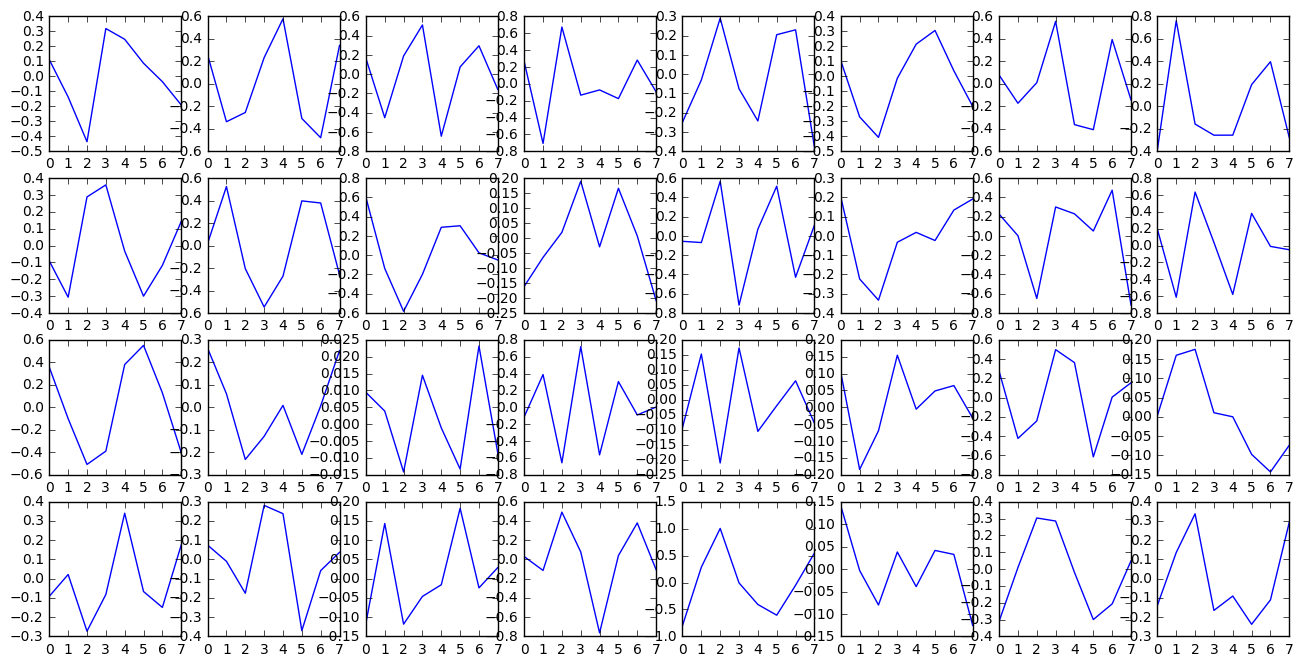

In [36]:
model = clf.model
for layer in model.layers:
    config = layer.get_config()
    if config['name'] == 'convolution1d_1':
        filters = np.squeeze(layer.get_weights()[0]).T
        h = 4
        w = 8
        fig, axarr = plt.subplots(h, w, figsize=(w*2, h*2))
        for i in range(h):
            for j in range(w):
                _ = axarr[i, j].plot(filters[i*w + j])